In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
from matplotlib import colors
import matplotlib.path as mpath

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

import os

import gsw
import pyresample
from xgcm import Grid

In [2]:
# read grid file for lon/lat coordinates
dg = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.variables["lat_rho"]
lon_rho_10km = dg.variables["lon_rho"]
lat_u_10km= dg.variables["lat_u"]
lon_u_10km = dg.variables["lon_u"]
lat_v_10km= dg.variables["lat_v"]
lon_v_10km = dg.variables["lon_v"]
cor_10km = dg.variables["f"]
pm_10km = dg.variables["pm"]
pn_10km = dg.variables["pn"]
zice_10km = dg.variables["zice"]
h_10km = dg.variables["h"]
dg.close()
print('Print lon/lat_rho shapes',lon_rho_10km.shape, lat_rho_10km.shape)
print('Print lon/lat_rho shapes',lon_rho_10km[0:-1,0:-1].shape, lat_rho_10km[0:-1,0:-1].shape)

Print lon/lat_rho shapes (560, 630) (560, 630)
Print lon/lat_rho shapes (559, 629) (559, 629)


In [3]:
# load ROMS avg output

def read_roms_ts_10km(exp_path):
    for yr  in ['20']:
        ds = xr.open_dataset(exp_path + 'ocean_avg_00' + yr + '.nc')
        print('size temp and time length: ', ds.temp.shape, len(ds.salt.isel(xi_rho=20, eta_rho=100, s_rho=0)))
        temp_tmp = ds.variables["temp"]
        salt_tmp = ds.variables["salt"]
        zeta_tmp = ds.variables["zeta"]
        melt_tmp = ds.variables["m"]
        temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
        salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
        melt_tmp_ann = np.nanmean(melt_tmp, axis=0)
        
        print('size temp_tmp_ann = ', temp_tmp_ann.shape)

        ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

        if ds.Vtransform == 1:
            Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
            z_rho_tmp = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
            print("Vtransform=1")
        elif ds.Vtransform == 2:
            Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
            z_rho_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_rho
            print("Vtransform=2")
        z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)

        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w_tmp = ds.zeta + (ds.zeta + ds.h) * Zo_w
        z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)

        # Handle interpolation from u and v grid to rho points:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

        coords={'X':{'center':'xi_rho', 'inner':'xi_u'},
            'Y':{'center':'eta_rho', 'inner':'eta_v'},
            'Z':{'center':'s_rho', 'outer':'s_w'}}

        grid = Grid(ds, coords=coords, periodic=[])

        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta + ds.zice
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta + ds.zice

        ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
        ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')

        ds['pm_v'] = grid.interp(ds.pm, 'Y')
        ds['pn_u'] = grid.interp(ds.pn, 'X')
        ds['pm_u'] = grid.interp(ds.pm, 'X')
        ds['pn_v'] = grid.interp(ds.pn, 'Y')
        ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u)
        ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

        ds['dx'] = 1/ds.pm
        ds['dx_u'] = 1/ds.pm_u
        ds['dx_v'] = 1/ds.pm_v
        ds['dx_psi'] = 1/ds.pm_psi

        ds['dy'] = 1/ds.pn
        ds['dy_u'] = 1/ds.pn_u
        ds['dy_v'] = 1/ds.pn_v
        ds['dy_psi'] = 1/ds.pn_psi
        
        ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
        ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
        ds['dz_u'] = grid.interp(ds.dz, 'X')
        ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
        ds['dz_v'] = grid.interp(ds.dz, 'Y')
        ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

        ds['dA'] = ds.dx * ds.dy

        metrics = {
            ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
            ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
            ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
            ('X', 'Y'): ['dA'] # Areas
        }
        grid = Grid(ds, coords=coords, metrics=metrics, periodic=False)

        u10_rho_sfc = np.zeros((12,560,630))
        v10_rho_sfc = np.zeros((12,560,630))
        u10_rho_bot = np.zeros((12,560,630))
        v10_rho_bot = np.zeros((12,560,630))

        for mm in np.arange(0,12):
            #interpoate u, v to rho grid:
            u10_interp = grid.interp(ds.u.isel(s_rho=0,ocean_time=mm), 'X',boundary='fill')
            v10_interp = grid.interp(ds.v.isel(s_rho=0,ocean_time=mm), 'Y',boundary='fill')
            u10_rho_bot[mm,:,:]=u10_interp
            v10_rho_bot[mm,:,:]=v10_interp
            del u10_interp,v10_interp
            u10_interp = grid.interp(ds.u.isel(s_rho=-1,ocean_time=mm), 'X',boundary='fill')
            v10_interp = grid.interp(ds.v.isel(s_rho=-1,ocean_time=mm), 'Y',boundary='fill')
            u10_rho_sfc[mm,:,:]=u10_interp
            v10_rho_sfc[mm,:,:]=v10_interp
            del u10_interp,v10_interp

        u10_rho_bot_ann = np.nanmean(u10_rho_bot, axis=0)
        v10_rho_bot_ann = np.nanmean(v10_rho_bot, axis=0)
        u10_rho_sfc_ann = np.nanmean(u10_rho_sfc, axis=0)
        v10_rho_sfc_ann = np.nanmean(v10_rho_sfc, axis=0)
        # concantenate annual averaged temp/salt
        if yr == '20':
            temp_ann = temp_tmp_ann
            salt_ann = salt_tmp_ann
            melt_ann = melt_tmp_ann
            u10_bot = u10_rho_bot_ann
            v10_bot = v10_rho_bot_ann
            u10_sfc = u10_rho_sfc_ann
            v10_sfc = v10_rho_sfc_ann

#     return temp_ann, salt_ann, u10_sfc, v10_sfc, u10_bot, v10_bot, melt_ann
    return melt_ann


In [9]:
path_ECCO2_10km = '/scratch/project_2000339/boeiradi/waom10extend_shflim_S_0.25Q/output_01-20yr/'
# temp_ann_10km, salt_ann_10km, u10_sfc, v10_sfc, u10_bot, v10_bot, melt_ann_10km = read_roms_ts_10km(path_ECCO2_10km)
melt_ann_10km = read_roms_ts_10km(path_ECCO2_10km)


size temp and time length:  (12, 31, 560, 630) 12


/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:11: RuntimeWarning: Mean of empty slice
  temp_tmp_ann = np.nanmean(temp_tmp, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:12: RuntimeWarning: Mean of empty slice
  salt_tmp_ann = np.nanmean(salt_tmp, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:13: RuntimeWarning: Mean of empty slice
  melt_tmp_ann = np.nanmean(melt_tmp, axis=0)


size temp_tmp_ann =  (31, 560, 630)
Vtransform=2


/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:27: RuntimeWarning: Mean of empty slice
  z_rho_tmp_ann = np.nanmean(z_rho_tmp, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:31: RuntimeWarning: Mean of empty slice
  z_w_tmp_ann = np.nanmean(z_w_tmp, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:102: RuntimeWarning: Mean of empty slice
  u10_rho_bot_ann = np.nanmean(u10_rho_bot, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:103: RuntimeWarning: Mean of empty slice
  v10_rho_bot_ann = np.nanmean(v10_rho_bot, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:104: RuntimeWarning: Mean of empty slice
  u10_rho_sfc_ann = np.nanmean(u10_rho_sfc, axis=0)
/run/nvme/job_14370398/tmp/ipykernel_1164077/2807465952.py:105: RuntimeWarning: Mean of empty slice
  v10_rho_sfc_ann = np.nanmean(v10_rho_sfc, axis=0)


In [10]:
mask_zice_10km = ma.masked_where(zice_10km < 0, np.ones(zice_10km.shape))
mask_outice_10km = ma.masked_where(zice_10km >= 0, np.ones(zice_10km.shape))

mask_shelf_10km = ma.masked_where(h_10km > 2000, np.ones(zice_10km.shape))


In [11]:
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Maps_validations/'

def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray')
    # longitude labels
    ax.text(0,-66,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(60,-53,'60$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(120,-53,'120$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-60,-48,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-120,-48,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray')
    ax.text(180,-60,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray')
    return

# define sections to investigate Ross-Filchner and Ross IS dynamics:
xi_pt = [850, 1000, 1275, 1550]
##xi_pt = [875, 1000, 1275, 1550] # new sections, too far east
eta_sec_ini = [1600, 1650,  750,  500]
eta_sec_end = [1945, 1970, 1075, 1196]

In [12]:
## Rignot data or Susheel?
import h5py
from scipy.interpolate import griddata


In [13]:
# # path = os.path.join('/scratch','project_2000339','boeiradi','postprocessing','susheel','ANT_iceshelf_melt_rates_CS2_2010-2018_v0_5km.h5')
# path = os.path.join('/scratch','project_2000339','boeiradi','postprocessing','susheel','bb0448974g.h5')

# sus = {}
# f = h5py.File(path)
# for k, v in f.items():
#     sus[k] = np.flipud(np.rot90(np.array(v)))
# f.close()

# mr=2
# x,y = np.meshgrid(np.arange(-3000,3300+mr/2,mr/2),np.arange(-2700,2600+mr/2,mr/2))
# x_rho = x[1::2,1::2]
# y_rho = y[1::2,1::2]


# x_sus,y_sus = np.meshgrid(sus['x'][0,::2],sus['y'][0,::2])
# x_sus,y_sus = x_sus.flatten()/1000,y_sus.flatten()/1000
# wb_sus = sus['w_b'][::2,::2].flatten()

# points = (x_sus,y_sus)

# print(x_rho.shape, y_rho.shape, x_sus.shape, wb_sus.shape)

# print(sus['x'].shape, sus['y'].shape, sus['w_b'].shape)

# wb_rho = xr.DataArray(griddata((x_sus,y_sus),wb_sus,(x_rho,y_rho)),dims=('eta_rho','xi_rho'))

# from visualization.shiftedColorMap import shiftedColorMap
# import matplotlib
# m_max=6
# m_min=-6

# m_cmap = shiftedColorMap(plt.cm.seismic,midpoint= (1 - m_max/(m_max + abs(m_min))))
# matplotlib.rcParams.update({'font.size': 18})

# plt.close()
# fig,ax = plt.subplots(figsize=(15,8))
# # wb_rho.plot(vmin=m_min,vmax=m_max,ax=ax,cmap=m_cmap,cbar_kwargs={'label':''})
# plt.pcolormesh(x_rho,y_rho, wb_rho, cmap=m_cmap)
# ax.set_aspect('equal')
# ax.axis('off')
# plt.tight_layout()
# plt.show()

In [14]:
# following Susheel github: https://github.com/sioglaciology/ice_shelf_change/blob/master/read_melt_rate_file.ipynb

# filename ='ANT/ANT_iceshelf_melt_rates_CS2_2010-2018_v0.h5'
filename = '/scratch/project_2000339/boeiradi/postprocessing/susheel/bb0448974g.h5'
is_wb = h5py.File(filename,'r')

x_wb = np.array(is_wb['/x'])
y_wb = np.array(is_wb['/y'])
wb = np.array(is_wb['/w_b'])

# extent = [np.min(is_wb['x']),np.max(is_wb['x']),np.min(is_wb['y']),np.max(is_wb['y'])]
# im_1 = ax1.imshow(np.flipud(wb),interpolation='none',vmin=-6, vmax=6, cmap='RdBu_r', extent=extent)

# x_sus,y_sus = np.meshgrid(x_wb,y_wb)
# print(x_sus.shape, y_sus.shape, wb.shape, x_wb.shape)

In [15]:
# interpolate Susheel data to WAOM grid:

mr=10

x,y = np.meshgrid(np.arange(-3000,3300+mr/10,mr/10),np.arange(-3000,2600+mr/10,mr/10))
x_rho = x[1::10,1::10]
y_rho = y[1::10,1::10]

x_sus,y_sus = np.meshgrid(x_wb[::10,0],y_wb[::10,0])
x_sus,y_sus = x_sus.flatten()/1000,y_sus.flatten()/1000
wb_sus = wb[::10,::10].flatten()

points = (x_sus,y_sus)

print(x_rho.shape, y_rho.shape, x_sus.shape, wb_sus.shape)

wb_rho = xr.DataArray(griddata((x_sus,y_sus),wb_sus,(x_rho,y_rho)),dims=('eta_rho','xi_rho'))


(560, 630) (560, 630) (1120185,) (1120185,)


In [16]:
print(wb_rho.shape, lon_rho_10km.shape, lat_rho_10km.shape, melt_ann_10km.shape)

(560, 630) (560, 630) (560, 630) (560, 630)


/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

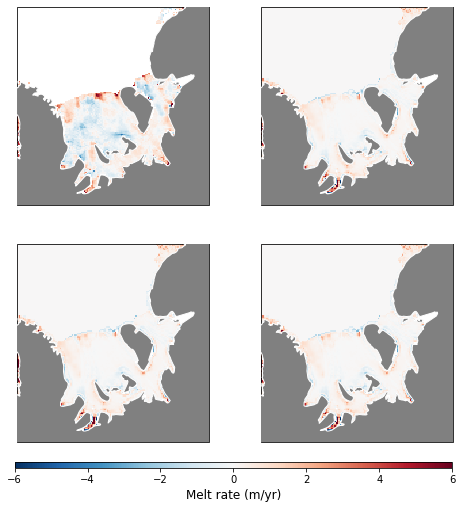

In [17]:
proj = ccrs.SouthPolarStereo()


# for FRIS region:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(221, projection=proj)
cm = plt.pcolormesh(lon_rho_10km,lat_rho_10km,wb_rho, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax1.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree()) # FRIS
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(222, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax2.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree()) # FRIS
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# ax2.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree()) # Whole-Antarctica

ax3 = fig.add_subplot(223, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax3.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree()) # FRIS
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(224, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax4.set_extent([-85, -30, -84, -74], crs=ccrs.PlateCarree()) # FRIS
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax1 = fig.add_axes([0.13, 0.08, 0.76, 0.01])
fig.colorbar(cm, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_xlabel('Melt rate (m/yr)',fontsize=12)#, labelpad=-35)

plt.show()

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/CSC_CONTAINER/miniconda/envs/env1/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

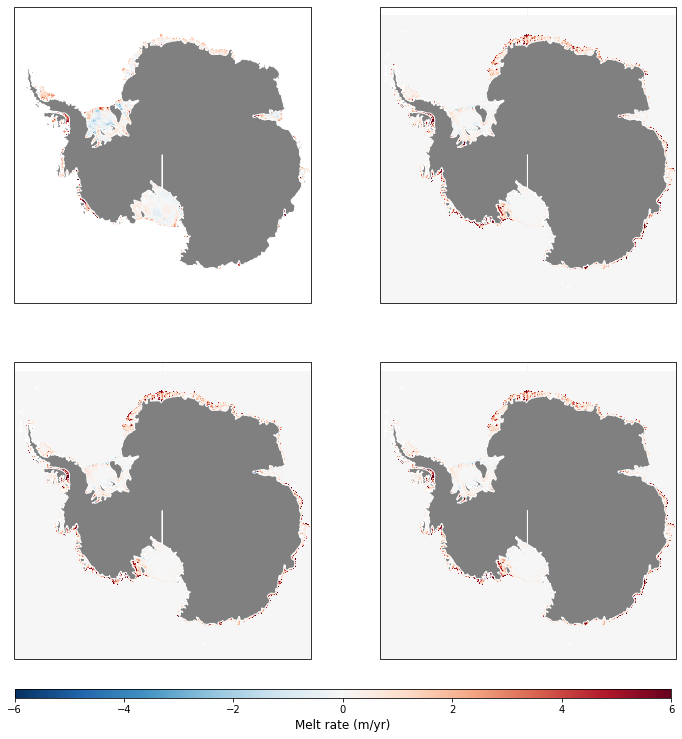

In [18]:
proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(221, projection=proj)
cm = plt.pcolormesh(lon_rho_10km,lat_rho_10km,wb_rho, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax1.set_extent([-180, 180, -84, -65], crs=ccrs.PlateCarree()) # FRIS
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax2 = fig.add_subplot(222, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax2.set_extent([-180, 180, -84, -65], crs=ccrs.PlateCarree()) # FRIS
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# ax2.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree()) # Whole-Antarctica

ax3 = fig.add_subplot(223, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax3.set_extent([-180, 180, -84, -65], crs=ccrs.PlateCarree()) # FRIS
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

ax4 = fig.add_subplot(224, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km,melt_ann_10km*365.25*86400, transform=ccrs.PlateCarree(), vmin=-6, vmax=6, cmap='RdBu_r')
ax4.set_extent([-180, 180, -84, -65], crs=ccrs.PlateCarree()) # FRIS
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')

cbar_ax1 = fig.add_axes([0.13, 0.08, 0.76, 0.01])
fig.colorbar(cm, cax=cbar_ax1, orientation='horizontal')
cbar_ax1.set_xlabel('Melt rate (m/yr)',fontsize=12)#, labelpad=-35)

plt.show()